<a href="https://colab.research.google.com/github/martabukow/PSI/blob/main/lab7/lab_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Systemy rekomendacyjne

## Wstęp

Celem laboratorium jest poznanie podstaw systemów rekomendacyjnych. Zapoznasz się na nim z następującymi tematami:
* budową systemów rekomendacyjnych typu collaborative filtering (CF), w szczególności z:
  * macierzą interakcji użytkownik-przedmiot (user-item matrix)
  * pojęciem biasu użytkownika i przedmiotu
  * analizą zbiorów danych do CF
  * metrykami jakości dla systemów rekomendacyjnych
* algorytmami globalnej rekomendacji:
  * metodami podstawowymi (baselines)
  * metodami bayesowskimi (Bayesian average)
* algorytmami personalizowanej rekomendacji typu CF, w szczególności z:
  * najbliższych sąsiadów (neighborhood-based) typu user-based oraz item-based
  * rozkładem macierzowym (matrix factorization) typu MF oraz FunkSVD

Jak zwykle, możesz albo korzystać z Google Colab, albo z własnego komputera. W obu przypadkach trzeba doinstalować trochę bibliotek.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/apohllo/sztuczna-inteligencja/blob/master/lab7/lab_7.ipynb)

## Krótki wstęp teoretyczny

**Systemy rekomendacyjne (recommender systems)** to dowolne metody mające rekomendować użytkownikom (users) pewne przedmioty (items). Korzysta z nich praktycznie każda większa firma: Netflix (filmy - "Top picks for you"), Spotify (muzyka, "Recommended for playlist"), Amazon (sklep - "frequently bought together) etc. Mają niesamowicie praktyczne zastosowanie i są jednym z najwcześniej oraz najczęściej wdrażanych metod uczenia maszynowego.

Jest to bardzo szeroka dziedzina, o bardzo różnorodnych podejściach. W szczególności można wyróżnić grupy:
1. **Collaborative filtering (CF)** - oparte o historię interakcji użytkowników z przedmiotami, czyli zwykle o historię ocen. Stąd pochodzą np. rekomendacje "użytkownicy podobni do ciebie oglądali także X", gdzie podobieństwo mierzy się na podstawie tego, jak bardzo podobne mieliśmy w przeszłości oceny do innych użytkowników. Co ważne, takie podejście nie wymaga żadnej inżynierii cech, a jedynie zapamiętania historii ocen / transakcji / interakcji!
2. **Content-based (CB)** - dużo bardziej podobne do klasycznego ML, tworzymy wektory cech dla przedmiotów, użytkowników i wykorzystujemy je w klasyfikacji (np. rekomendować lub nie) lub regresji (np. liczba gwiazdek).
3. **Algorytmy hybrydowe** - łączące podejścia CF i CB podczas nauki. Są zazwyczaj bardziej złożone i wymagają odpowiednio dużych zbiorów danych.

Dodatkowo możemy podzielić problemy rekomendacji na dwa rodzaje, w zależności od tego, czym są nasze **oceny (ratings)**:
1. **Explicit feedback** - kiedy użytkownicy jawnie podają oceny, np. ocena hotelu w skali 1-10, liczba gwiadek dla przedmiotu. Wymaga to większej proaktywności użytkowników, więc potencjalnie możemy mieć mniej danych, ale są często bardziej precyzyjne. Są też typowo prostsze teoretycznie (matematycznie), bo mają znany z góry, ograniczony zakres możliwych wartości.
2. **Implicit feedback** - kiedy jakość przedmiotu wyznaczają akcje użytkowników, np. liczba kliknięć, liczba udostępnień. Takie informacje można gromadzić automatycznie i bardzo łatwo, ale mogą być mało precyzyjne (np. przypadkowe kliknięcia, boty). Algorytmy dla takich problemów są też cięższe do zaprojektowania, bo mamy tylko wartości nieujemne i typowo nieograniczone z góry.

Same rekomendacje mogą być dwojakiego rodzaju:
1. **Globalne (global)** - biorą pod uwagę ogólne cechy przedmiotu i są oceniane dla całej społeczności, nie pod konkretnych użytkowników. Korzystają z nich typowo strony z wiadomościami, żeby ułożyć kolejność postów na stronie, np. HackerNews, Reddit. Przydają się też, gdy nie mamy dość informacji o użytkowniku, aby dokonać personalizacji.
2. **Personalizowane (personalized)** - zasadnicze zastosowanie systemów rekomendacyjnych, w którym "profilujemy" użytkownika lub przedmiot, tak, aby nauczyć sie relacji między nimi i sugerować to, co konkretną osobę może interesować.

Na tym laboratorium skupimy się na systemach typu collaborative filtering, bo są:
1. Ciekawsze i bardziej unikatowe na tle tych algorytmów, które już poznaliśmy.
2. Często o wiele łatwiejsze w praktycznej implementacji, gdyż nie wymagają feature engineeringu.
3. Bardzo szybkie i skalowalne.
4. Zazwyczaj lepsze pod względem wyników od systemów content-based.

Skupimy się na systemach typu explicit ranking, bo są nieco prostsze i popularniejsze. Poznamy za to i systemy globalne, i personalizowane.

Czemu więc korzystać z innego podejścia niż CF? O tym przekonasz się w późniejszej części labu :)

## Biblioteki do systemów rekomendacyjnych

Do systemów rekomendacyjnych nie istnieje jedna standardowa, powszechnie przyjęta biblioteka, taka jak Scikit-learn. Jest to bowiem zbyt rozległa dziedzina, oparta o bardzo różnorodne podejścia i rozwiązania, aby dało się ją zamknąć w jednej bibliotece ze spójnym interfejsem. Można jednak wyróżnić zbiór najpopularniejszych bibliotek. Co ważne, praktyczne systemy implementuje się jednak często od zera, pod konkretny problem.

1. [Surprise](https://surpriselib.com/) - od niedawna `scikit-surprise` ze względu na implementację interfejsów ze Scikit-learn'a. Implementuje algorytmy typu explicit rating collaborative filtering.
2. [Implicit](https://benfred.github.io/implicit/) - podobna do Surprise, implementuje algorytmy typu implicit rating collaborative filtering.
3. [LibRecommender](https://github.com/massquantity/LibRecommender) - rozbudowana biblioteka, implementująca różne podejścia: collaborative filtering, feature-based, oraz hybrydowe. Zawiera algorytmy pisane od zera, w TensorFlow (niestety v1) oraz w PyTorchu, z wielu artykułów naukowych. Ma jednak dość specyficzny, niekoniecznie intuicyjny interfejs.
4. [Spark MLlib](https://spark.apache.org/docs/latest/ml-collaborative-filtering.html) - de facto standard w pracy z wielkimi zbiorami danych, częstymi w systemach rekomendacyjnych. Implementuje explicit oraz implicit collaborative filtering.
5. [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) - de facto standard dla grafowych sieci neuronowych (Graph Neural Networks, GNNs), które są m. in. najnowszym trendem w systemach rekomendacyjnych opartych o grafy (graph-based recommender systems).

Dodatkowo dla podejścia content-based (opisane, ale nie implementowane w tym laboratorium) można użyć dowolnej biblioteki do uczenia nadzorowanego, typowo Scikit-learn lub Spark MLlib.

Na tym laboratorium wykorzystamy `Surprise` ze względu na prostotę użycia.

# Ściąganie, ładowanie i eksploracja danych

Na początek ściągniemy nasz zbiór danych. Będziemy pracować na zbiorze MovieLens-100k, czyli zbiorze 100 tysięcy ocen filmów. Strona MovieLens udostępnia wiele rozmiarów tego zbioru danych, a ten będzie odpowiednio szybki na potrzeby edukacyjne. W praktyce wykorzystuje się zbiory rozmiaru co najmniej takiego, jak MovieLens-1M (zbiór miliona ocen).

Opis plików można znaleźć w [readme](https://files.grouplens.org/datasets/movielens/ml-100k-README.txt). Najważniejsze fragmenty:
```
u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of
	         user id | item id | rating | timestamp.
              The time stamps are unix seconds since 1/1/1970 UTC   
```

Zbiór co prawda ma już przygotowany podział do 5-krotnej walidacji skrośnej (pliki `u1.base`, `u1.test` etc.), ale my wykonamy ten podział sami. Gotowych podziałów używa się w pracach naukowych, aby móc porównywać wyniki różnych algorytmów na dokładnie tych samych zbiorach treningowych i testowych.

In [1]:
!wget -N https://files.grouplens.org/datasets/movielens/ml-100k.zip

--2025-01-27 22:25:35--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  4.95MB/s    in 0.9s    

2025-01-27 22:25:36 (4.95 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [2]:
!unzip -n ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [3]:
import os
import pandas as pd


df = pd.read_csv(
    os.path.join("ml-100k", "u.data"),
    sep="\t",
    header=None,
    names=["user_id", "item_id", "rating", "timestamp"],
)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
print(f"Number of reviews: {len(df)}")
print(f"Ratings range: {df.rating.min(), df.rating.max()}")

Number of reviews: 100000
Ratings range: (1, 5)


Tabela w formacie jak powyżej to de facto słownik `(user_id, item_id) -> rating`. Jest zatem idealna do podejścia collaborative filtering, w którym dla **użytkowników (users)** mamy ich **oceny (ratings)** wybranych **przedmiotów (items)**. Tutaj oczywiście przedmiotami są filmy. Można by zatem z takich danych zbudować **macierz ocen (ratings matrix)**, w której wiersze byłyby użytkownikami, kolumny przedmiotami, a komórki zawierałyby oceny.


W przyszłości chcemy zatem **przewidywać wartości brakujące** macierzy ocen. Mamy tu zatem poniekąd problem regresji - chcemy dostać wartość ciągłą, np. na ile użytkownik oceniłby film, którego jeszcze nie widział. Późniejsza rekomendacja to po prostu wybranie najwyższych predykcji i zaproponowanie tych właśnie przedmiotów. Nazywa się to czasem problemem **uzupełnienia macierzy (matrix completion)**.

W praktyce **nigdy** nie należy budować macierzy ocen explicite. Zwyczajnie nie zmieściłaby się ona do pamięci dla zbiorów o prawdziwym rozmiarze, kiedy mamy setki tysięcy użytkowników i przedmiotów. Dodatkowo zwyczajnie nie ma to sensu, bo nasze macierze prawie zawsze są **rzadkie (sparse)**, tzn. mają wypełnioną tylko nieznaczną liczbę pól. Reszta jest nieznana - w końcu pojedynczy człowiek obejrzy tylko niewielką część wszystkich filmów z Netflixa, nie mówiąc już o wystawieniu im ocen.

## Zadanie 1 (0.5 punktu)

Oblicz gęstość (density) macierzy ocen dla naszego zbioru danych. Jest to liczba ocen, podzielona przez rozmiar macierzy ocen (liczba użytkowników * liczba przedmiotów). Wynik przedstaw w procentach, zaokrąglony do 4 miejsc po przecinku. Pamiętaj, żeby uwzględnić tylko unikatowych użytkowników i przedmioty.

In [5]:
# your_code

N = len(df)
U = df["user_id"].nunique()
I = df["item_id"].nunique()

density = round((N / (U * I)) * 100, 4)
print(density)

6.3047


In [6]:
assert 6 <= density <= 7

W praktyce często zbiory mają gęstość rzędu 1% lub mniejszą. Jest to też pozytywne - w końcu to dzięki temu mamy komu robić rekomendacje (i czego).

Warto zauważyć, że nasz zbiór zawiera tylko tych użytkowników, którzy ocenili przynajmniej 20 filmów, a zatem wiemy o każdym z nich całkiem sporo. Unika to problemu **zimnego startu (cold start)**, w którym nic nie wiemy o nowych użytkownikach i/lub filmach. W prawdziwych systemach jest to jednak duże wyzwanie. Można sobie z nim radzić na kilka sposobów:
- rekomendować najpopularniejsze przedmioty
- rekomendować przedmioty o najwyższych ocenach
- użyć globalnego (niepersonalizowanego) systemu rekomendacyjnego, np. przewidywanie średniej dla przedmiotu
- używać systemu content-based, bo radzą sobie dobrze przy małej liczbie interakcji
- poprosić użytkownika przy pierwszym logowaniu o podanie pierwszych preferencji (nie zawsze możliwe)

W związku z problemem zimnego startu systemy rekomendacyjne zwykle są (co najmniej) dwuetapowe i mają osobny algorytm dla nowych użytkowników/przedmiotów oraz osobny dla tych, o których już coś wiemy więcej i możemy dokonywać personalizacji.

Zbadajmy teraz rozkład popularności poszczególnych przedmiotów w naszym zbiorze.

## Zadanie 2 (0.5 punktu)

Narysuj wykres popularności (liczby ocen) dla poszczególnych przedmiotów. Użyj odpowiednio dużej liczby kubełków histogramu, żeby zwizualizować kształt.

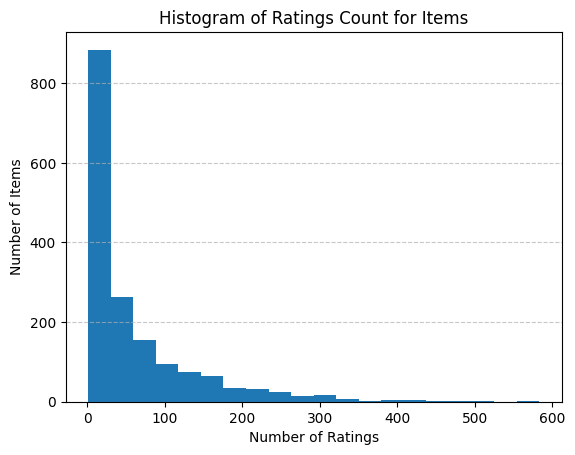

In [7]:
# your_code
import matplotlib.pyplot as plt

item_ratings_count = df.groupby("item_id").size()

plt.hist(item_ratings_count, bins=20)
plt.title("Histogram of Ratings Count for Items")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Items")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Typowo niewielka liczba przedmiotów odpowiada za większość ocen. Są to rzeczy bardzo znane i popularne, napędzane efektem kuli śnieżnej. Przykładowo, "Titanic" ogląda i ocenia bardzo znaczna liczba użytkowników, przez sam fakt, jak bardzo znany jest ten film. My jesteśmy zwykle zainteresowani **długim ogonem (long tail)** naszego rozkładu popularności, czyli zwiększeniem popularności tych przedmiotów, które są mniej znane, a które możemy zaoferować użytkownikom, np. nowa muzyka do odkrycia.

**Eksploracja danych - podsumowanie**

1. W systemach typu collaborative filtering operujemy na macierzy ocen, gdzie wierszami są użytkownicy, kolumnami oceny, a w komórkach znajdują się oceny.
2. Macierz ocen jest zwykle bardzo rzadka.
3. Kiedy niewiele wiemy o użytkowniku lub przedmiocie, to mamy problem zimnego startu, z którym trzeba sobie w jakiś sposób poradzić.
4. Często występuje zjawisko długiego ogona, czyli dominacji niewielkiej grupy bardzo popularnych przedmiotów.

# Walidacja modeli, prosty model bazowy

Na początek, zanim zaczniemy budować nasze modele, trzeba wyodrębnić zbiór testowy. Mamy tutaj kilka możliwości. Po pierwsze, można po prostu losowo, tak jak to robiliśmy do tej pory, i tak bardzo często się robi.

Zbiór testowy ma jednak symulować przyszłe dane, przybliżać zdolność generalizacji modelu, a my mamy do dyspozycji znaczniki czasowe, z kiedy pochodzą dane oceny. Można by więc użyć **podziału czasowego (time split)**, czyli wyodrębnić najnowsze oceny do zbioru testowego, a konkretnie najnowsze oceny per użytkownik. Stanowi to bardzo dobrą symulację tego, jak w praktyce działa system.

Powyższe podejścia mają jednak pewne ryzyko - może się zdarzyć, że tak wylosujemy zbiór testowy, że dla jakiegoś użytkownika 90% ocen jest w zbiorze testowym, więc spowodujemy u niego przypadkiem problem zimnego startu. Analogicznie może być przy podziale czasowym, kiedy jakiś nowy użytkownik był aktywny tylko niedawno i być może nawet wszystkie jego predykcje trafiłyby do zbioru testowego. Dlatego można stosować **podział per użytkownik**, wyodrębniając np. losowe 10% ocen każdego użytkownika jako zbiór testowy.

Jak widać, jest tu nieco ciężej niż przy zwykłej klasyfikacji czy regresji. Dla uproszczenia wykorzystamy zwykły podział losowy. Implementacje innych metod można znaleźć np. w bibliotece LibRecommender.

Surprise definiuje 2 ważne klasy: `Dataset` i `Trainset`. Ta pierwsza reprezentuje surowe dane, a druga wstępnie przetworzone dane do treningu lub testowania. Interfejs jest tutaj dość dziwny, ale w skrócie:
- do zwykłych algorytmów idą `train_set` i `test_set`
- do `GridSearchCV` idą `data_train` i `test_set`

In [8]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 6.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505165 sha256=e356d180cbc6d8a0d1f6014e44b88516c24115825e21af8baf42329ff725e1ae
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [9]:
from copy import deepcopy

from sklearn.model_selection import train_test_split
from surprise.dataset import Dataset, Reader

reader = Reader(rating_scale=(df["rating"].min(), df["rating"].max()))
dataset = Dataset.load_from_df(df[["user_id", "item_id", "rating"]], reader=reader)

ratings_train, ratings_test = train_test_split(
    dataset.raw_ratings, test_size=0.2, random_state=1
)

data_train = deepcopy(dataset)
data_train.raw_ratings = ratings_train

train_set = data_train.build_full_trainset()
test_set = data_train.construct_testset(ratings_test)

Na początek zaimplementujemy model, który przewiduje po prostu wartość średnią dla każdego przedmiotu. Nie ma on żadnych hiperparametrów, więc nawet nie będziemy potrzebować zbioru walidacyjnego. Jest to bardzo dobry **model bazowy (baseline)** w systemach rekomendacyjnych.

## Zadanie 3 (1 punkt)

Uzupełnij kod klasy `ItemAveragePredictor`, która przewiduje wartość średnią dla każdego przedmiotu. Może ci się tutaj przydać atrybut `ir` (item rating) klasy `Trainset` - [dokumentacja](https://surprise.readthedocs.io/en/stable/trainset.html), oraz [dokumentacja tworzenia własnych algorytmów](https://surprise.readthedocs.io/en/stable/building_custom_algo.html).

Dobrym pomysłem będzie przechowywanie danych w postaci atrybutu będącego słownikiem w `.fit()`, żeby zapamiętać mapowanie `item_id` -> średnia ocena.

Uwaga - zgodnie z konwencją ze Scikit-learn atrybuty, których wartości są obliczane (estymowane) na podstawie danych treningowych, są tworzone w metodzie `.fit()` i mają underscore `_` na końcu nazwy, np. `self.ratings_`.

In [10]:
import numpy as np
from surprise import AlgoBase, PredictionImpossible


class ItemAveragePredictor(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)

        # mapping: item_id -> average rating
        self.ratings_ = {}

        # compute average rating for each item
        for item_id in self.trainset.all_items():
            ratings = [r for (u, r) in self.trainset.ir[item_id]]
            self.ratings_[item_id] = np.mean(ratings)

        # your_code

        return self

    def estimate(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")

        return self.ratings_[i]

In [11]:
algo = ItemAveragePredictor()
algo.fit(train_set)
pred_item_avg = algo.test(test_set)
pred_item_avg[:5]

[Prediction(uid=508, iid=185, r_ui=5.0, est=4.075376884422111, details={'was_impossible': False}),
 Prediction(uid=518, iid=742, r_ui=5.0, est=3.632850241545894, details={'was_impossible': False}),
 Prediction(uid=178, iid=28, r_ui=5.0, est=3.897777777777778, details={'was_impossible': False}),
 Prediction(uid=899, iid=291, r_ui=4.0, est=3.4591836734693877, details={'was_impossible': False}),
 Prediction(uid=115, iid=117, r_ui=4.0, est=3.664451827242525, details={'was_impossible': False})]

In [12]:
assert 3.45 <= np.mean([pred.est for pred in pred_item_avg]) <= 3.6

Musimy teraz ocenić jakość naszego algorytmu. Jako że mamy tu problem regresji, to naturalnym wyborem są **RMSE (root mean squared error)** oraz **MAE (Mean Absolute Error)**. Pokażą nam one, jak bardzo średnio nasz model myli się w przewidywaniu ratingu.

RMSE to po prostu pierwiastek błędu średniokwadratowego (MSE). Ma taką samą wadę przy ewaluacji jak MSE - zwraca zbyt dużą uwagę na obserwacje odstające (outliers). Dzięki pierwiastkowaniu ma tę samą jednostkę, co oryginalne dane.
$$\large
RMSE = \sqrt{MSE} = \sqrt{\frac{1}{N} \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2}
$$

MAE to średnie odchylenie predykcji od wartości prawdziwej. Dzięki zastosowaniu wartości bezwzględnej zamiast kwadratu jest miarą bardziej odporną na outliery i dlatego często wykorzystywaną przy ewaluacji. Ma naturalnie tę samą jednostkę, co mierzona wartość.
$$\large
MAE = \frac{1}{N} \sum_{i=1}^N \left| y_i - \hat{y}_i \right|
$$

Ze względu na to, że Surprise nie zwraca zwykłego wektora Numpy'a, tylko obiekty `Prediction`, trzeba użyć metryk z tej biblioteki, albo zaimplementować własne.

In [13]:
from surprise.accuracy import rmse, mae

rmse(pred_item_avg, verbose=True)
mae(pred_item_avg, verbose=True)

RMSE: 1.0231
MAE:  0.8153


0.8153345185529649

Wygląda na to, że nawet najprostszy model nie radzi sobie wcale tak źle. Ale są to tylko przewidywane wartości - zobaczmy faktyczne rekomendacje. W praktyce mamy ograniczone miejsce, np. mało kto popatrzy na więcej niż pierwsze 5-10 rekomendowanych filmów. W związku z tym nieważne nawet, co będzie dalej - liczy się dla nas **top k** predykcji.

Zgromadzimy teraz faktyczne najlepsze oceny ze zbioru testowego dla każdego użytkownika, rekomendacje naszego systemu i zbierzemy je w jednen DataFrame.

In [14]:
from surprise import Prediction


def get_user_recommendations(user_rec_items: pd.Series) -> list[int]:
    return user_rec_items.sort_values(ascending=False).index.tolist()


def get_recommendations(predictions: list[Prediction]) -> pd.DataFrame:
    df_pred = pd.DataFrame(predictions)
    df_pred = df_pred.drop(columns="details")
    df_pred.columns = ["user_id", "item_id", "actual", "prediction"]

    df = (
        df_pred.groupby("user_id", as_index=False)["item_id"]
        .agg({"actual": (lambda x: list(x))})
        .set_index("user_id")
    )

    df_pivot = df_pred.pivot_table(
        index="user_id", columns="item_id", values="prediction"
    ).fillna(0)

    df["recommendations"] = [
        get_user_recommendations(df_pivot.loc[user_id]) for user_id in df.index
    ]

    return df


rec_item_avg = get_recommendations(pred_item_avg)
rec_item_avg

<ipython-input-14-987cb180a48d>:15: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  .agg({"actual": (lambda x: list(x))})


,actual,recommendations
user_id,,
1,"[186, 122, 182, 81, 83, 249, 48, 116, 90, 94, ...","[64, 136, 174, 48, 23, 83, 242, 74, 182, 238, ..."
2,"[255, 251, 242, 10, 1, 285, 258, 283, 257, 269...","[251, 285, 127, 242, 269, 1, 10, 258, 257, 283..."
3,"[288, 355, 320, 343, 341, 342, 326]","[320, 288, 326, 341, 343, 355, 342, 970, 976, ..."
4,"[258, 361]","[258, 361, 975, 973, 972, 971, 970, 969, 968, ..."
5,"[401, 413, 21, 194, 227, 40, 408, 151, 243, 38...","[408, 173, 194, 189, 216, 144, 1, 200, 204, 37..."
...,...,...
939,"[9, 409, 689, 1190, 471, 118, 222]","[9, 222, 471, 1190, 118, 689, 409, 967, 973, 9..."
940,"[147, 95, 98, 357, 471, 382, 1167, 164, 527, 2...","[285, 357, 98, 427, 172, 651, 527, 430, 213, 2..."
941,[117],"[117, 1, 996, 971, 970, 969, 968, 967, 966, 96..."


Teraz kiedy można porównać faktyczne predykcje, patrząc np. na top 5, to nie wygląda to już tak dobrze, jak trzeba wybrać konkretne filmy. Do mierzenia jakości wśród top k predykcji służą metryki:
- mean average precision at k (MAP@k)
- mean average recall at k (MAR@k)
- Fraction of Concordant Pairs (FCP)
- Normalized Discounted Cumulative Gain (NDCG)

Są one używane w systemach rekomendacyjnych, ale też w wyszukiwarkach i niektórych problemach NLP. Dla MAP i MAR dokładny opis, krok po kroku, możesz znaleźć [tutaj](https://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html) i [tutaj](https://machinelearninginterview.com/topics/machine-learning/mapatk_evaluation_metric_for_ranking/). FCP doskonale opisuje [oryginalny artykuł](https://www.ijcai.org/Proceedings/13/Papers/449.pdf). [Tutaj](https://finisky.github.io/2019/04/24/ndcg/) krótki i treściwy artykuł o NDCG.


## MAP@k

Zdefiniujmy:
- True Positive (TP) - przedmiot, który naprawdę jest w top k (*relevant*) i który nasz system zarekomendował w top k przedmiotów
- False Positive (FP) - przedmiot, który nie jest w top k (*nonrelevant*), ale nasz model go zarekomendował w top k

"Precision at k" to precyzja (precision), obliczona dla top k przedmiotów. Oznaczmy przez $r_k$ liczbę TP (*relevant items*) wśród top k przedmiotów.
$$\large
P@k = \frac{\text{number of relevant items in top }k}{k} = \frac{r_k}{k}
$$

"Average P@k" to po prostu P@k obliczone dla różnych $i=1,2,...,k$ i uśrednione. Taka agregacja bardzo penalizuje umieszczanie nieciekawych przedmiotów na wysokich miejscach, bo uwzględniamy tylko precyzję dla tych top k, gdzie prawidłowo zauważyliśmy TP.
$$\large
AP@k = \frac{1}{r_k} \sum_{i=1}^{k} \left( P@i \text{ if i-th item is relevant} \right)
$$

MAP@k to AP@k (average precision at k), uśrednione dla wszystkich $|U|$ użytkowników:
$$\large
MAP@k = \frac{1}{|U|} \sum_{u=1}^{|U|}AP@k(u)
$$

Im niższe $k$, tym surowsi jesteśmy i tym niższe będą wyniki - nasz algorytm ma mniej miejsca na błąd. Typowo $k=5$ lub $k=10$. Zakres wartości MAP@k to $[0, 1]$.

MAP@k przykłada bardzo dużą wagę do tego, żeby na pierwszych miejscach trafiły się jak najlepsze przedmioty. Jest zatem bardzo ważne, kiedy mamy mało miejsc do dyspozycji, np. przy rekomendacji filmów na głównej stronie (Netflix).


## FCP

FCP (Fraction of Concordant Pairs) jest rzadziej używaną, ale bardzo intuicyjną metryką. Ideą jest uogólnienie metryki AUROC (ROC AUC) na algorytmy rankujące, a więc systemy rekomendacyjne. Ma zakres wartości $[0, 1]$.

Liczba zgodnych par (*concordant pairs*) $n_c^u$ dla użytkownika $u$ to liczba par przedmiotów, które zostały prawidłowo uporządkowane przez ranker. Innymi słowy, gdy mamy prawdziwy ranking ocen użytkownika oraz przewidywany, to jest to liczba par przedmiotów, które prawidłowo ułożyliśmy (lepszy przedmiot wyżej niż gorszy).
$$\large
n_c(u) = |\{ (i,j) | \hat{r}_{ui} > \hat{r}_{uj} \text{ and } r_{ui} > r_{uj}\}|
$$

Pary niezgodne (*discordant pairs*) liczy się podobnie:
$$\large
n_d(u) = |\{ (i,j) | \hat{r}_{ui} > \hat{r}_{uj} \text{ and } r_{ui} \leq r_{uj}\}|
$$

Proporcja par zgodnych do wszystkich, zsumowana dla wszystkich użytkowników, to FCP:
$$\large
FCP = \frac{n_c}{n_c + n_c} = \frac{\sum_{i=1}^n n_c(u)}{\sum_{i=1}^n n_c(u) + n_d(u)}
$$

Można także obliczyć FCP@k, ograniczając się do pierwszych k predykcji.

Metryka FCP przykłada mniejszą wagę niż MAP@k do tego, żeby najlepsze przedmioty były jak najwyżej. Skupia się natomiast na tym, żeby lepsze przedmioty były powyżej gorszych. Działa więc lepiej dla rekomendacji dłuższych list, kiedy pierwsze pozycje nie są aż tak ważne, np. przy rekomendowaniu playlist muzyki (Spotify).

## Zadanie 4 (1 punkt)

Uzupełnij kod funkcji `ap_k`, która oblicza AP@k dla pojedynczego użytkownika. Pamiętaj, aby ograniczyć się do najwyższych (pierwszych) `k` przedmiotów dla rekomendacji oraz predykcji. W przypadku, gdy model nie miał żadnej dobrej predykcji ($r_k = 0$), zwróć 0.

Następnie oblicz i wypisz MAP@k oraz FCP (k=10) dla naszego modelu średniej przedmiotu. Wartości podaj w procentach.

In [15]:
def ap_k(y_true: list[int], y_pred: list[int], k: int) -> float:

    # your_code
    y_pred = y_pred[:k]
    y_true = y_true[:k]

    relevant_items = 0
    sum_precision = 0

    for i, pred_item in enumerate(y_pred, start=1):
        if pred_item in y_true:
            relevant_items += 1
            precision_at_i = relevant_items / i
            sum_precision += precision_at_i

    if relevant_items == 0:
        return 0

    return sum_precision / relevant_items


In [16]:
from collections import defaultdict
from operator import itemgetter

from surprise.accuracy import fcp


def map_k(df: pd.DataFrame, k: int) -> float:
    ap_k_values = []
    for idx, row in df.iterrows():
        actual, recommendations = row
        ap_k_val = ap_k(actual, recommendations, k)
        ap_k_values.append(ap_k_val)

    return np.mean(ap_k_values)


def fcp_k(predictions: list[Prediction], k: int) -> float:
    top_k = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_k[uid].append((iid, est))

    user_item_id_pairs = set()

    for user_id, user_ratings in top_k.items():
        user_ratings.sort(key=itemgetter(1), reverse=True)
        for item_id, rating in user_ratings[:k]:
            user_item_id_pairs.add((user_id, item_id))

    predictions_top_k = [
        pred for pred in predictions if (pred[0], pred[1]) in user_item_id_pairs
    ]

    return fcp(predictions_top_k, verbose=False)

In [17]:
map_k_item_avg = map_k(rec_item_avg, k=10)
fcp_item_avg = fcp_k(pred_item_avg, k=10)

print(f"Item average model MAP@k (k=10): {100 * map_k_item_avg:.2f}%")
print(f"Item average model FCP@k (k=10): {100 * fcp_item_avg:.2f}%")

Item average model MAP@k (k=10): 74.55%
Item average model FCP@k (k=10): 60.60%


In [18]:
assert 0.73 <= map_k_item_avg <= 0.75
assert 0.59 <= fcp_item_avg <= 0.62

Zobaczymy, że ten wynik da się jeszcze poprawić.

Metryki MAP@k i MAR@k mają jednak pewną wadę - preferują sugerowanie popularnych treści przez model, bo można je łatwo umieścić wysoko w rekomendacji i łatwo podbić sobie precyzję. W ten sposób rekomendacje byłyby słabo personalizowane. Dlatego wykorzystuje się szereg innych metryk, głównie biorących pod uwagę różnorodność i personalizację rekomendacji, na przykład:
- pokrycie (*coverage*) - procent przedmiotów ze zbioru, który nasz system w ogóle rekomenduje
- nowość (*novelty*) - zdolność systemu do rekomendacji zaskakujących, nowych dla użytkownika przedmiotów
- personalizacja (*personalization*) - miara różnicy między rekomendacjami dla poszczególnych użytkowników

Możesz o nich poczytać więcej [w tym artykule](https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093).

**Pomiar jakości systemów rekomendacyjnych - podsumowanie**

1. Poza stosowaniem zwykłego podziału losowego train-test można też stosować podział czasowy lub per użytkownik.
2. Jednym z najprostszych modeli i dobrym punktem odniesienia (baseline) jest przewidywanie średniej per przedmiot.
3. Podstawowymi metrykami jakości są metryki dla regresji: RMSE i MAE, oraz rankowania: MAP@k, MAR@k, NDCG.
4. Inne metryki, specyficzne dla rekomendacji, biorą pod uwagę jakość personalizowanych rekomendacji, np. pokrycie, nowość, personalizacja.

# Model średniej bayesowskiej

Masz ochotę na dobrą pizzę i szukasz opinii na Google Maps. Masz do wyboru 2 lokale: jeden ze średnią 5.0 i drugi ze średnią 4.8. Zauważasz jednak, że pierwszy ma tylko 5 opinii, a drugi 200. Który wybierzesz? Są spore szanse, że ten drugi, bo mamy większą **pewność (confidence)** co do oceny takiego lokalu.

Prosty model, taki jak średnia przedmiotu, ma ten sam problem, co powyżej. Sformalizowaniem idei "chcę być pewny, że ocena przedmiotu jest wysoka" jest model **średniej bayesowskiej (Bayesian average)**. Możliwych sformułowań bayesowskich jest dużo, ale ogólna idea jest zawsze taka, aby wziąć pod uwagę rozkład ocen przedmiotu oraz ich liczbę. Co ważne, to dalej są rekomendacje globalne - mamy jedną predykcję per przedmiot.

Czemu średnia "bayesowska"? Przypomnijmy sobie twierdzenie Bayesa:
$$\large
P(Y|X) = \frac{P(X|Y) \cdot P(Y)}{P(X)}
$$

W naszym wypadku:
1. $X$ - zbiór danych, który jest stały.
2. $Y$ - przewidywane wartości.
3. $P(X)$ - prawdopodobieństwo zaobserwowania naszych danych, które co prawda ciężko jest zmierzyć, ale na szczęście w ML zwykle możemy zignorować mianownik, bo to tylko stała.
4. $P(Y)$ - *prior* (*prior distribution*), czyli z góry założony rozkład prawdopodobieństw wartości, które przewidujemy. Często zaczynamy bez żadnej wiedzy, więc zakładamy rozkład jednostajny lub normalny.
5. $P(X|Y)$ - *likelihood*, wiarygodność, czyli jak dobrze model odwzorowuje dotychczas zaobserwowane dane.
6. $P(Y|X)$ - *posterior* (*posterior distribution*), czyli docelowy rozkład wartości przewidywanych, obliczony na podstawie danych.

W kontekście systemów rekomendacyjnych:
- $P(Y)$ (prior) to założony z góry rozkład ocen, typowo jednostajny, czyli jest taka sama szansa na każdą ocenę
- $P(X|Y)$ (likelihood) to miara, jak dobrze nasz model odwzorowuje macierz ocen; jakbyśmy potraktowali go jako skrzynkę generującą oceny, to wiarygodność mierzy, jak bliskie są te generowane wartości wobec prawdziwych ze zbioru danych
- $P(Y|X)$ (posterior) to rozkład przewidywanych ocen dla poszczególnych przedmiotów

Jak widać, dostajemy rozkład w wyniku. Jak dostać konkretną predykcję, czyli np. liczbę gwiazdek? Używamy **maximum a posteriori (MAP)**, czyli bierzemy po prostu tę ocenę, dla której rozkład posterior ma największą wartość.

Wykorzystamy podejście opisane krok po kroku [w tym artykule](https://fulmicoton.com/posts/bayesian_rating/) oraz [tym tutorialu](https://www.algolia.com/doc/guides/managing-results/must-do/custom-ranking/how-to/bayesian-average/), w którym przewidywana ocena dla $i$-tego przedmiotu (po przekształceniach) to:
$$\large
r_i = \frac{C \cdot m + \text{suma ocen dla przedmiotu } i}{C + \text{liczba ocen}}
$$

gdzie:
- $m$ - prior, globalna średnia ocen dla wszystkich przedmiotów
- $C$ - confidence, liczba ocen dla przedmiotu
- liczba ocen

Dodatkowe źródła:
- [artykuł o twierdzeniu Bayesa](https://towardsdatascience.com/understand-bayes-rule-likelihood-prior-and-posterior-34eae0f378c5)
- [proste i przyjazne sformułowanie średniej bayesowskiej](https://arpitbhayani.me/blogs/bayesian-average)
- [bardziej wyrafinowane podejście oparte o dolną granicę błędu](https://www.evanmiller.org/how-not-to-sort-by-average-rating.html)
- [bardzo wyrafinowane podejście oparte o dolną granicę błędu - dla odważnych](https://www.evanmiller.org/ranking-items-with-star-ratings.html)
- [średnia bayesowska dla danych zmiennych w czasie](https://www.evanmiller.org/bayesian-average-ratings.html)

## Zadanie 5 (1 punkt)

Uzupełnij kod klasy `BayesianAveragePredictor`. W metodzie `.fit()` musisz obliczyć parametry:
- sumę ocen dla każdego przedmiotu
- liczbę ocen dla każdego przedmiotu
- globalną pewność (confidence, $C$)

Pewność oblicz jako dolny kwartyl (25 percentyl) rozkładu liczby ocen przedmiotów, zgodnie z [tym tutorialem](https://www.algolia.com/doc/guides/managing-results/must-do/custom-ranking/how-to/bayesian-average/#how-to-calculate-the-bayesian-average). Przyda ci się funkcja `np.quantile()`.

Sugerowane jest używanie słowników w `.fit()`, żeby mapować `item_id` na odpowiednią wartość.

W metodzie `.estimate()` musisz zastosować obliczone parametry we wzorze podanym powyżej.

Dokonaj predykcji i oblicz metryki za pomocą podanej funkcji. Skomentuj wynik w porównaniu do przewidywania średniej przedmiotu.

In [19]:
class BayesianAveragePredictor(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)

        self.global_avg_ = trainset.global_mean

        # mapping: item_id -> sum of ratings
        self.ratings_sums_ = dict()

        # mapping: item_id -> number of ratings
        self.ratings_counts_ = dict()

        # compute rating sum for each item
        ...
        for item_id in trainset.all_items():
            ratings = [r for (u, r) in trainset.ir[item_id]]
            self.ratings_sums_[item_id] = np.sum(ratings)
            self.ratings_counts_[item_id] = len(ratings)


        # confidence (C)
        self.confidence_ = np.quantile(list(self.ratings_counts_.values()), 0.25)

        # your_code

        return self

    def estimate(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")

        # compute score formula
        score = (self.confidence_ * self.global_avg_ + self.ratings_sums_[i]) / (self.confidence_ + self.ratings_counts_[i])

        # your_code

        return score

In [20]:
def print_metrics(
    predictions: list[Prediction], recommendations: pd.DataFrame, k: int = 10
) -> None:
    rmse(predictions, verbose=True)
    mae(predictions, verbose=True)
    map_k_value = map_k(recommendations, k=k)
    fcp_k_value = fcp_k(predictions, k=k)

    print(f"MAP@k ({k=}): {100 * map_k_value:.2f}%")
    print(f"FCP@k ({k=}): {100 * fcp_k_value:.2f}%")

In [21]:
algo = BayesianAveragePredictor()
algo.fit(train_set)
pred_bayes_avg = algo.test(test_set)
rec_bayes_avg = get_recommendations(pred_bayes_avg)

# calculate and print metrics

print_metrics(pred_bayes_avg, rec_bayes_avg)

<ipython-input-14-987cb180a48d>:15: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  .agg({"actual": (lambda x: list(x))})


RMSE: 1.0224
MAE:  0.8166
MAP@k (k=10): 74.44%
FCP@k (k=10): 60.50%


In [22]:
assert 1 <= rmse(pred_bayes_avg, verbose=False) <= 1.1

// skomentuj tutaj

Wyniki są do siebie zbliżone



# Metody oparte o sąsiedztwo

Mając solidne punkty odniesienia w postaci rekomendacji globalnych, możemy przejść do rekomendacji personalizowanych. W metodach **opartych o sąsiedztwo (neighborhood-based)** znajdujemy podobnych użytkowników do nas, albo przedmioty podobne do tych które lubiliśmy, i na podstawie tego dokonujemy rekomendacji.

Podejście to jest używane także w innych obszarach uczenia maszynowego, np. w algorytmie k najbliższych sąsiadów (*k nearest neighbors*, kNN), SMOTE, albo w identyfikacji osób (znajdujemy 1 najbliższego sąsiada dla embeddingu twarzy). Wymaga ono odpowiedniej metryki, która zmierzy odległość między wektorami, znajdując k najbliższych sąsiadów, z których następnie wyciągamy informacje.

## User-based neighborhood-based CF

Idea podejścia **user-based** jest bardzo prosta - znajdźmy użytkowników podobnych do nas, którzy oceniali przedmioty, których my jeszcze nie widzieliśmy, i zasugerujmy to, co potencjalnie najbardziej będzie się nam podobać. Realizuje podejście "użytkownicy podobni do ciebie oglądali także...".

Algorytm user-based collaborative filtering działa następująco:
1. Dla każdego użytkownika znajdź k najbliższych sąsiadów
2. Predykcja dla przedmiotu to średnia ocena sąsiadów dla tego przedmiotu, którzy ocenili dany przedmiot
3. Zarekomenduj te przedmioty, które mają najwyższą przewidywaną ocenę

Co ważne, przy obliczaniu najbliższych użytkowników bierzemy tylko te przedmioty, które obaj ocenili. Przykładowo, jeżeli użytkownik $u_1$ ocenił przedmioty $[1, 2, 3]$, a użytkownik $u_2$ ocenił przedmioty $[2, 3, 4]$, to na potrzeby obliczania ich podobieństwa bierzemy pod uwagę tylko $[2, 3]$. Przy obliczaniu predykcji dla $i$-tego przedmiotu także bierzemy pod uwagę tylko tych najbliższych sąsiadów, którzy wystawili mu ocenę.

Predykcja dla użytkownika $u$ i przedmiotu $i$ to:
$$\large
\hat{r}_{ui} = \frac{\sum_{v \in N_i^k(u)} \text{sim}(u, v) * r_{vi}}{\sum_{v \in N_i^k(u)} \text{sim}(u, v)}
$$
gdzie:
- $N_i^k(u)$ - $k$ najbliższych sąsiadów dla użytkownika $u$, którzy ocenili przedmiot $i$
- $r_{vi}$ - ocena przedmiotu $i$ przez użytkownika $v$
- $\text{sim}(u, v)$ - podobieństwo użytkowników $u$ i $v$ według metryki $\text{sim}$

Co ważne, tutaj metryka jest podobieństwem, tzn. większa wartość = bardziej podobni użytkownicy. Typowo używa się **korelacji Pearsona (Pearson correlation)**, która przyjmuje wartości z zakresu $[-1, 1]$. Dzięki temu wiemy, którzy użytkownicy są bardzo podobni (blisko 1), którzy mają wręcz przeciwny gust do naszego (blisko -1), a którzy są w ogóle inni od nas (blisko 0). Niektóre implementacje (np. Surprise) biorą pod uwagę tylko sąsiadów o nieujemnej korelacji, a inne wykorzystują tę informację z ujemną wagą.

In [23]:
from surprise.prediction_algorithms.knns import KNNBasic

knn_basic = KNNBasic(sim_options={"name": "pearson"})
knn_basic.fit(train_set)
pred_knn_basic = knn_basic.test(test_set)
rec_knn_basic = get_recommendations(pred_knn_basic)

print_metrics(pred_knn_basic, rec_knn_basic)

Computing the pearson similarity matrix...
Done computing similarity matrix.


<ipython-input-14-987cb180a48d>:15: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  .agg({"actual": (lambda x: list(x))})


RMSE: 1.0107
MAE:  0.8016
MAP@k (k=10): 74.08%
FCP@k (k=10): 61.41%


Wynik nie jest może idealny, ale nie przeprowadziliśmy jeszcze żadnego tuningu hiperparametrów.

Najważniejszym hiperparametrem jest **liczba sąsiadów `k`**. Trzeba wziąć pod uwagę, że nie wszystkie przedmioty będą się pokrywać między użytkownikami, więc typowo bierze się ich dość dużo. Jeżeli dana implementacja uwzględnia tylko nieujemne korelacje, to jeszcze więcej sąsiadów może odpaść, więc trzeba wziąć większą wartość. Jest to więc de facto maksymalna liczba sąsiadów do uwzględnienia. Im większa wartość, tym mocniejsza regularyzacja, bo uśredniamy więcej użytkowników. Przede wszystkim należy jednak wziąć pod uwagę wielkość naszego zbioru, szczególnie liczbę użytkowników oraz gęstość.

Drugim hiperparametrem jest **minimalna liczba sąsiadów `min_k`**. Jeżeli spośród `k` najbliższych sąsiadów mniej niż `min_k` oceniło dany przedmiot, to mamy zimny start. Zwykle wykorzystuje się wtedy algorytm globalny, np. przewidując globalną średnią. Jak widać, system rekomendacyjny składa się w środku z bardzo wielu systemów rekomendacyjnych :)

## Zadanie 6 (1 punkt)

Przeprowadź tuning hiperparametrów, używając 10-krotnej walidacji skrośnej i optymalizując MAE. Jako że nasz zbiór jest dość mały, to sprawdzimy zakres:
```
param_grid = {
    "k": list(range(10, 51, 10)),
    "min_k": list(range(1, 4)),
    "sim_options": {"name": ["pearson"]},
    "random_state": [0],
    "verbose": [False]
}
```

Jako że interesują nas przede wszystkim same rekomendacje, optymalizuj metrykę FCP. Wypisz znalezione najlepsze hiperparametry oraz metryki na zbiorze testowym dla najlepszego modelu.

Wskazówki:
- `GridSearchCV` z biblioteki Surprise
- argument `refit` ma domyślną wartość `False`, inaczej niż w Scikit-learn'ie
- argument `n_jobs`
- niestety `random_state` trzeba przekazać jako hiperparametr, API Surprise jest tutaj niezbyt dobrze zrobione ([Github issue](https://github.com/NicolasHug/Surprise/issues/212))
- analogicznie do powyższego trzeba przekazać dość dziwnie `sim_options`
- analogicznie do powyższego działa przekazywanie `verbose` (żeby uniknąć zalewu tekstu)

Skomentuj wyniki i zmiany w poszczególnych metrykach.

In [24]:
# your_code
from surprise.model_selection import GridSearchCV


param_grid = {
    "k": list(range(10, 51, 10)),
    "min_k": list(range(1, 4)),
    "sim_options": {"name": ["pearson"]},
    "random_state": [0],
    "verbose": [False]
}

gs = GridSearchCV(KNNBasic, param_grid, measures=["mae", "fcp"], cv=10, n_jobs=-1, refit=True)
gs.fit(data_train)

best_params = gs.best_params["fcp"]
best_score = gs.best_score["fcp"]

print("Best hiperparameters (FCP):", best_params)
print("Best score (FCP):", best_score)

knn_basic_tuned = gs.best_estimator["fcp"]
knn_basic_tuned.fit(train_set)
pred_knn_basic_tuned = knn_basic_tuned.test(test_set)
rec_knn_basic_tuned = get_recommendations(pred_knn_basic_tuned)

print_metrics(pred_knn_basic_tuned, rec_knn_basic_tuned)


Best hiperparameters (FCP): {'k': 50, 'min_k': 1, 'sim_options': {'name': 'pearson', 'user_based': True}, 'random_state': 0, 'verbose': False}
Best score (FCP): 0.6862403823715555


<ipython-input-14-987cb180a48d>:15: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  .agg({"actual": (lambda x: list(x))})


RMSE: 1.0101
MAE:  0.8014
MAP@k (k=10): 74.14%
FCP@k (k=10): 61.40%


In [25]:
assert 1 <= rmse(pred_knn_basic_tuned, verbose=False) <= 1.02

// skomentuj tutaj



Ten algorytm nie bierze jednak psychologicznych różnic między użytkownikami. Niektórzy użytkownicy będą średnio zawyżać oceny, bo film to dla nich luźna rozrywka, a poważni koneserzy mogą dawać filmom średnio dość niskie oceny. Taka tendencja to **user bias**, ale na szczęście można go policzyć - to po prostu średnia ocena wystawiana przez użytkownika, a więc średnia z każdego wiersza w macierzy ocen.

Jeżeli od każdego wiersza odejmiemy jego średnią, to dostaniemy **ratings deviations**, czyli nie mamy już w macierzy samych ocen, tylko jak bardzo ocena danego przedmiotu przez użytkownika różni się od jego średniej predykcji. Taka operacja to **centrowanie (centering)**. Na takich wartościach można też zwyczajnie liczyć najbliższych sąsiadów, a korelacja Pearsona dalej działa dla takich danych. Żeby dokonać predykcji, przewidujemy odchylenie dla przedmiotu, a następnie dodajemy je dla średniej danego użytkownika.

Mamy zatem:
$$\large
\hat{r}_{ui} = \mu_i + \frac{\sum_{v \in N_i^k(u)} \text{sim}(u, v) * (r_{vi} - \mu_v)}{\sum_{v \in N_i^k(u)} \text{sim}(u, v)}
$$

## Zadanie 7 (0.5 punktu)

Analogicznie do poprzedniego zadania wytrenuj, zoptymalizuj i sprawdź na zbiorze treningowym user-based CF z centrowaniem (`KNNWithMeans`). Wypisz także optymalny zestaw hiperparametrów dla obu algorytmów.

Skomentuj uzyskane hiperparametry i wyniki.

In [26]:
# your_code
from surprise import KNNWithMeans


param_grid = {
    "k": list(range(10, 51, 10)),
    "min_k": list(range(1, 4)),
    "sim_options": {"name": ["pearson"], "user_based": [True]},
    "random_state": [0],
    "verbose": [False]
}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["mae", "fcp"], cv=10, n_jobs=-1, refit=True)
gs.fit(data_train)

best_params_knn_centered = gs.best_params["fcp"]
best_score_knn_centered = gs.best_score["fcp"]


knn_centered_tuned = gs.best_estimator["fcp"]
knn_centered_tuned.fit(train_set)
pred_knn_centered_tuned = knn_centered_tuned.test(test_set)
rec_knn_centered_tuned = get_recommendations(pred_knn_centered_tuned)

print_metrics(pred_knn_centered_tuned, rec_knn_centered_tuned)

print("Best hiperparameters for KNNBasic (FCP):", best_params)
print("Best score:", best_score)

print("Best hiperparameters for KNNWithMeans (FCP):", best_params_knn_centered)
print("Best score:", best_score_knn_centered)



<ipython-input-14-987cb180a48d>:15: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  .agg({"actual": (lambda x: list(x))})


RMSE: 0.9447
MAE:  0.7374
MAP@k (k=10): 73.83%
FCP@k (k=10): 61.26%
Best hiperparameters for KNNBasic (FCP): {'k': 50, 'min_k': 1, 'sim_options': {'name': 'pearson', 'user_based': True}, 'random_state': 0, 'verbose': False}
Best score: 0.6862403823715555
Best hiperparameters for KNNWithMeans (FCP): {'k': 50, 'min_k': 1, 'sim_options': {'name': 'pearson', 'user_based': True}, 'random_state': 0, 'verbose': False}
Best score: 0.6847183896481637


In [27]:
assert 0.92 <= rmse(pred_knn_centered_tuned, verbose=False) <= 0.97

// skomentuj tutaj



## Item-based neighborhood-based CF

Idea podejścia **item-based** jest bardzo podobna do user-based, ale znajdujemy podobne przedmioty, a nie użytkowników. Operujemy zatem na kolumnach macierzy ocen. Realizuje to podejście "mogą cię jeszcze zainteresować przedmioty..." oraz "skoro oglądałeś X, to mogą spodobać ci się...".

Predykcja dla użytkownika $u$ i przedmiotu $i$ to:
$$\large
\hat{r}_{ui} = \frac{\sum_{j \in N_u^k(i)} \text{sim}(u, v) * r_{uj}}{\sum_{j \in N_u^k(i)} \text{sim}(u, v)}
$$

Podobieństwo przedmiotów liczymy tutaj według kolumn macierzy, a metryką jest zwykle **podobieństwo cosinusowe (cosine similarity)**. Wykorzystuje się także centrowanie, eliminując **item bias** - przykładowo, "Titanic" będzie miał zwykle zawyżone oceny, bo każdy słyszał, że to znany i dobry film, więc podświadomie zawyżymy mu ocenę. Metrykę po centralizacji nazywa się czasem *adjusted cosine similarity*.

Podejście item-based zazwyczaj daje większą dokładność niż used-based, tzn. niższe RMSE i MAE. Skutkuje to jednak niższym pokryciem czy nowością. Takie podejście potrafi być też bardziej czułe na zimny start.

## Zadanie 8 (0.5 punktu)

Zaimplementuj podejście item-based z metryką cosinusową w wariantach:
- bez normalizacji
- z centrowaniem (adjusted cosine)

Analogicznie do poprzedniego ćwiczenia zastosuj optymalizację hiperparametrów, podaj najlepszy zestaw oraz wypisz metryki na zbiorze testowym.

Żeby zamienić algorytm user-based na item-based, oraz zmienić metrykę, przyda ci się [ten tutorial](https://surprise.readthedocs.io/en/stable/getting_started.html#tune-algorithm-parameters-with-gridsearchcv).

Skomentuj, jaką uzyskano różnicę względem user-based i które rozwiązanie twoim zdaniem jest lepsze.

In [28]:
# your_code
param_grid = {
    "k": list(range(10, 51, 10)),
    "min_k": list(range(1, 4)),
    "sim_options": {"name": ["cosine"], "user_based": [False]},
    "random_state": [0],
    "verbose": [False]
}

gs_item = GridSearchCV(KNNBasic, param_grid, measures=["mae", "fcp"], cv=10, n_jobs=-1, refit=True)
gs_item.fit(data_train)

best_params_knn_item = gs_item.best_params["fcp"]
best_score_knn_item = gs_item.best_score["fcp"]

print("Best hiperparameters without normalization (FCP):", best_params_knn_item)
print("Best score (FCP):", best_score_knn_item)

knn_item_tuned = gs_item.best_estimator["fcp"]
knn_item_tuned.fit(train_set)
pred_knn_item_tuned = knn_item_tuned.test(test_set)
rec_knn_item_tuned = get_recommendations(pred_knn_item_tuned)

print_metrics(pred_knn_item_tuned, rec_knn_item_tuned)


gs_item_centered = GridSearchCV(KNNWithMeans, param_grid, measures=["mae", "fcp"], cv=10, n_jobs=-1, refit=True)
gs_item_centered.fit(data_train)

best_params_knn_item_centered = gs_item_centered.best_params["fcp"]
best_score_knn_item_centered = gs_item_centered.best_score["fcp"]

print("Best hiperparameters with centering (FCP):", best_params_knn_item_centered)
print("Best score:", best_score_knn_item_centered)

knn_item_centered_tuned = gs_item_centered.best_estimator["fcp"]
knn_item_centered_tuned.fit(train_set)
pred_knn_item_centered_tuned = knn_item_centered_tuned.test(test_set)
rec_knn_item_centered_tuned = get_recommendations(pred_knn_item_centered_tuned)

print_metrics(pred_knn_item_centered_tuned, rec_knn_item_centered_tuned)


Best hiperparameters without normalization (FCP): {'k': 50, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': False}, 'random_state': 0, 'verbose': False}
Best score (FCP): 0.5898181400424567


<ipython-input-14-987cb180a48d>:15: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  .agg({"actual": (lambda x: list(x))})


RMSE: 1.0197
MAE:  0.8063
MAP@k (k=10): 73.97%
FCP@k (k=10): 55.65%
Best hiperparameters with centering (FCP): {'k': 50, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': False}, 'random_state': 0, 'verbose': False}
Best score: 0.6774025857055832


<ipython-input-14-987cb180a48d>:15: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  .agg({"actual": (lambda x: list(x))})


RMSE: 0.9363
MAE:  0.7341
MAP@k (k=10): 74.24%
FCP@k (k=10): 60.92%


In [29]:
assert 1 <= rmse(pred_knn_item_tuned, verbose=False) <= 1.03
assert 0.92 <= rmse(pred_knn_item_centered_tuned, verbose=False) <= 0.97

// skomentuj tutaj



## Metody oparte o sąsiedztwo - podsumowanie

Podsumowanie:
1. Możemy wyróżnić dwa sposoby liczenia sąsiadów: user-based (inni użytkownicy, wiersze macierzy) oraz item-based (inne przedmioty, kolumny macierzy).
2. Podejście user-based wykorzystuje zwykle korelację Pearsona, a item-based podobieństw cosinusowe.
3. Użytkownicy oraz przedmioty mają naturalny bias (user bias, item bias), który można wyeliminować, stosując normalizację: centrowanie lub standaryzację.

Zalety:
1. Prostota
2. Interpretowalność, szczególnie dla item-based
3. Stosunkowo niewielka czułość na dobór hiperparametrów
4. Można idealnie uwspółbieżnić trening oraz predykcję (embarassingly parallel)

Wady:
1. Dość trudna implementacja, trzeba wybierać wspólne przedmioty
2. Trening jest niezbyt skalowalny dla bardzo dużych danych
3. Czułe na zimny start
4. Bardzo niewiele implementacji wspiera dodawanie nowych użytkowników/przedmiotów - trzeba przetrenowywać regularnie cały model

# Metody oparte o rozkład macierzy

Podejście najbliższych sąsiadów definiuje "sąsiedztwo" bardzo explicite - wymaga, by użytkownicy ocenili dokładnie te same filmy, aby w ogóle sprawdzać, czy są podobni. Nie wykorzystuje to niejawnych podobieństw między przedmiotami i filmami. Przykładowo, jeżeli jeden lubi filmy "Szeregowiec Ryan", "Dunkierka" i "Wróg u bram", a drugi lubi filmy "Czas apokalipsy" i "Jak rozpętałem drugą wojnę światową", to są do siebie bardzo podobni, a jednak podejście user-based nawet nie będzie w stanie tego sprawdzić. Item-based mogłoby tu nieco pomóc, ale tam mogą się zdarzyć analogiczne sytuacje.

Podejście oparte o rozkład macierzy, spopularyzowane w ramach konkursu Netflix Prize 2007 przez Simona Funka ([wywiad](https://www.kdd.org/exploration_files/simon-funk-explorations.pdf), [jego blog](https://sifter.org/simon/journal/20061211.html)), rozwiązuje właśnie ten problem. Stanowi kamień milowy w systemach rekomendacyjnych, gdyż jest daje bardzo dobre wyniki, doskonale uwspółbieżnia się i rozprasza na wiele maszyn, a do tego jest naprawdę proste. Szczegółowy i bardzo przystępny opis tego podejścia można znaleźć w artykule ["Matrix factorization techniques for recommender systems" Y. Koren, R. Bell, C. Volinsky](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf).

Ideą jest, aby dokonać **rozkładu macierzy (matrix decomposition)** na macierzy ocen $R$, przybliżając ją jako iloczyn dwóch macierzy $W$ (user matrix) i $U$ (item matrix), które reprezentują użytkowników i przedmioty po dekompozycji:
$$\large
\hat{R} = WU^T
$$

![matrix_decomposition.png](attachment:matrix_decomposition.png)

Załóżmy, że mamy $N$ użytkowników i $M$ przedmiotów. Kształty to zatem:
$$\large
\hat{R}_{N \times M} = W_{N \times K} U_{K \times N}^T
$$

Pojawił nam się nowy wymiar $K$ - każdy użytkownik to teraz wektor z macierzy $W$ o długości $K$, a każdy przedmiot to wektor z macierzy $U$ o długości $K$. Jest to **ukryta wymiarowość (latent dimensionality)**, stanowiąca hiperparametr, analogiczny np. do rozmiaru warstw sieci neuronowej. Nie są to interpretowalne cechy, ale można zauważyć przy dobrym modelu, że odwzorowują pewne ogólne tematy w danych. Przykładowo, dla filmów (przedmiotów) mogą oznaczać, jak dużo jest poszczególnych tematów w filmie, np. "romans", "komedia", "akcja". Dla użytkowników mogą oznaczać, w jak dużym stopniu użytkownik interesuje się danym tematem. Typowe wartości $K$ to około kilkadziesiąt-kilkaset. Ze względu na wykorzystanie latent dimension takie modele nazywa się też **latent factor models**.

Predykcji w takim modelu dokonuje się przez iloczyn skalarny wektora użytkownika (wiersz $W$) z wektorem przedmiotu (kolumna $U$):
$$\large
r_{ui} = w_u^Tu_i
$$

Dzięki takiemu sformułowaniu, jeśli zainteresowanie użytkownika tematem $k$ będzie duże, a film będzie zawierał dużo tematu $k$, to ich mnożenie da dużą wartość, a zatem dużą predykcję.

Algorytm ten nazywa się czasem niepoprawnie SVD, bo takiej nazwy użył Simon Funk do opisu swojego algorytmu (jego wersja ma trochę ulepszeń; będziemy ją nazywać FunkSVD). Co ważne, nie wykorzystujemy tutaj algorytmu SVD, bo nie potrzebujemy całego jego aparatu matematycznego. Zamiast tego ten algorytm to po prostu **matrix factorization (MF)**, tudzież **Probabilistic Matrix Factorization (PMF)** ([oryginalny artykuł PMF](https://proceedings.neurips.cc/paper/2007/file/d7322ed717dedf1eb4e6e52a37ea7bcd-Paper.pdf) dowodzi, że to sformułowanie jest poprawne probabilistycznie). Trenuje się go także bez SVD, zamiast tego wykorzystując spadek wzdłuż gradientu lub algorytm **Alternating Least Squares (ALS)**. Ciężko powiedzieć, które podejście jest lepsze, patrz np. [ta dyskusja](https://stats.stackexchange.com/questions/201279/comparison-of-sgd-and-als-in-collaborative-filtering), [ten paper](http://cs229.stanford.edu/proj2014/Christopher%20Aberger,%20Recommender.pdf).Oba podejścia bardzo dobrze opisuje [ten artykuł](https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/), który rozwija też bardziej formalnie, czemu ekstrakcja "tematów" działa (spoiler: MF dokonuje implicite klasteryzacji).

Niezależnie od podejścia, minimalizuje się funkcję kosztu, czyli różnicę między naszym przybliżeniem $\hat{R} = WU^T$ a prawdziwą macierzą $R$. Zwykle wykorzystuje się tutaj błąd średniokwadratowy, w zapisie macierzowym $||\hat{R} - R||_2^2$. Zapisując to ręcznie:
$$\large
L = \sum_{u, i \in \Omega} \left( r_{ui} - \hat{r}_{ui} \right)^2
$$
gdzie $\Omega$ to zbiór wszystkich wypełnionych komórek w macierzy ocen.

Jako że mamy dwie macierze do nauczenia, $W$ oraz $U$, to mamy pochodną po wektorach $w$ oraz po wektorach $u$. Po przekształceniach dostajemy:
$$\large
w_i = \left( \sum_{j \in \Psi_i} u_ju_j^T \right)^{-1} \sum_{j \in \Psi_i} r_{ij}u_j
$$
$$\large
u_j = \left( \sum_{i \in \Omega_j} w_iw_i^T \right)^{-1} \sum_{i \in \Omega_j} r_{ij}w_i
$$
gdzie:
- $\Psi_i$ oznacza zbiór przedmiotów, które ocenił użytkownik $i$
- $\Omega_j$ oznacza zbiór użytkowników, którzy ocenili przedmiot $j$

Można zauważyć, że w obu przypadkach jest to zwyczajny nadokreślony (*overdetermined*) układ równań postaci $x=A^{-1}b$. Taki problem rozwiązuje się metodą najmniejszych kwadratów (*ordinary least squares*), stąd część nazwy metody. Oczywiście do rozwiązania problemu OLS można użyć SVD.

Przybliżymy teraz krótko metodę ALS, bo SGD znamy już z sieci neuronowych. Można zauważyć w powyższych wzorach, że dla $W$ pochodna zależy od wartości w $U$, a dla $U$ od wartości w $W$ - wydaje się, że sytuacja patowa. Rozwiązaniem jest po prostu przyjąć losowy punkt wyjścia, a potem raz rozwiązywać $W$ za pomocą $U$, a raz na odwrót.

Pełny algorytm ALS:
1. Zainicjalizuj losowo macierze $W$ i $U$ niewielkimi wartościami z rozkładu normalnego
2. Powtarzaj przez T kroków:
  1. Zaktualizuj $U$ według wzoru, rozwiązując układ równań; $W$ jest stałe
  2. Zaktualizuj $W$ według wzoru, rozwiązując układ równań; $U$ jest stałe

Co ważne, zbieżność i ALS, i spadku wzdłuż gradientu jest gwarantowana, ale do minimum lokalnego. Zwykle nie stanowi to jednak problemu, a w razie czego zawsze można wytrenować wiele modeli na różnych `random_state` i wybrać najlepszy. Liczba epok treningowych stanowi dość prosty hiperparametr - im więcej, tym dokładniejsi po prostu będziemy, więc możemy bardziej overfitować (analogicznie do sieci neuronowych). Zazwyczaj w przypadku ALS wystarcza niewielka liczba, kilka-kilkanaście.

Surprise implementuje wersję z SGD. Wersję z ALS implementuje np. Apache Spark. Wersję z SGD można też łatwo zaimplementować w dowolnym frameworku do sieci neuronowych, np. PyTorch czy TensorFlow.

In [30]:
from surprise.prediction_algorithms.matrix_factorization import SVD

# regular MF - no user/item bias, no regularization
mf = SVD(biased=False, reg_all=0, random_state=0)
mf.fit(train_set)
pred_mf = mf.test(test_set)
rec_mf = get_recommendations(pred_mf)

print_metrics(pred_mf, rec_mf)

<ipython-input-14-987cb180a48d>:15: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  .agg({"actual": (lambda x: list(x))})


RMSE: 0.9671
MAE:  0.7596
MAP@k (k=10): 74.12%
FCP@k (k=10): 60.76%


Dostaliśmy całkiem dobry wynik bez żadnego tuningu, a czeka nas jeszcze trochę ulepszeń, bo powyższy algorytm to jeszcze nie słynny FunkSVD.

Skoro user bias i item bias pomagały w metodach opartych o sąsiedztwo, to dodajmy je też tutaj, czemu nie. Najpierw możemy odjąć od wszystkiego globalną średnią $\mu$, żeby wycentrować całą macierz. Potem odejmujemy od każdego wiersza user bias $b_u$, a na koniec od każdej kolumny item bias $b_i$. Predykcja to zatem:
$$\large
\hat{r}_{ui} = \mu + b_u + b_i + w_u^Tu_i
$$

Drugie ulepszenie to dodanie regularyzacji do naszej funkcji kosztu. W końcu nie możemy się zbyt bardzo dostosować do zbioru treningowego, nasz algorytm ma generalizować się dla przyszłych rekomendacji. Co ważne, mamy tutaj aż 4 możliwe źródła przeuczenia:
- $b_u$ - zbytnie dostosowanie do dotychczasowych odchyleń użytkowników
- $b_i$ - analogicznie, ale dla przedmiotów
- $w_i$ - jest to wektor wag, więc duże wagi oznaczają overfitting, jak np. w regresji liniowej
- $u_i$ - analogicznie, ale dla drugiej macierzy

Można by użyć 4 osobnych współczynników regularyzacji, ale optymalizacja takiej siatki hiperparametrów jest raczej mało wykonalna. Można więc użyć jednego hiperparametru na moc regularyzacji L2 $\lambda$, włączając do niego wszystkie parametry. Daje to funkcję kosztu:
$$\large
L = \sum_{u, i \in \Omega} \left( r_{ui} - \hat{r}_{ui} \right)^2 + \lambda \left( ||W||_2^2 + ||U||_2^2 + ||b_u||_2^2 + ||b_i||_2^2 \right)
$$

Pomijając dalsze wyprowadzenie, nic nie zmienia to w gruncie rzeczy w algorytmie ALS, dalej możemy użyć zwykłego OLS, zmienią się tylko trochę wartości w macierzach. Niewiele zmienia się też, gdy używamy spadku wzdłuż gradientu - dodajemy tylko regularyzację do funkcji kosztu.

Powyższe sformułowanie to już pełny algorytm FunkSVD. Zobaczmy, jak sobie poradzi.

In [31]:
funk_svd = SVD(biased=True, random_state=0)
funk_svd.fit(train_set)
pred_funk_svd = funk_svd.test(test_set)
rec_funk_svd = get_recommendations(pred_funk_svd)

print_metrics(pred_funk_svd, rec_funk_svd)

<ipython-input-14-987cb180a48d>:15: FutureWarning: Passing a dictionary to SeriesGroupBy.agg is deprecated and will raise in a future version of pandas. Pass a list of aggregations instead.
  .agg({"actual": (lambda x: list(x))})


RMSE: 0.9308
MAE:  0.7323
MAP@k (k=10): 74.05%
FCP@k (k=10): 61.08%


Wygląda to na bardzo dobry wynik, a nie dokonaliśmy jeszcze żadnego tuningu hiperparametrów.

## Zadanie 9 (1 punkt)

Zaimplementuj tuning hiperparametrów dla algorytmu FunkSVD, sprawdzając siatkę hiperparametrów:
```
param_grid = {
    "n_factors": list(range(50, 151, 10)),
    "lr_all": [0.001, 0.003, 0.005, 0.007, 0.01],
    "reg_all": [0.01, 0.02, 0.03]
}
```

Pamiętaj, aby przekazać stałe `random_state`! Przyda się też `n_jobs`. Jeżeli na twoim sprzęcie będzie się to liczyć o wiele za długo, to możesz zmniejszyć zakres `n_factors` do 80-121.

Skomentuj wyniki.

In [33]:
# your_code

param_grid = {
    "n_factors": list(range(50, 151, 10)),
    "lr_all": [0.001, 0.003, 0.005, 0.007, 0.01],
    "reg_all": [0.01, 0.02, 0.03],
    "random_state": [0]
}

gs = GridSearchCV(SVD, param_grid, measures=["mae", "fcp"], cv=10, n_jobs=-1, refit=True)
gs.fit(data_train)

best_params= gs.best_params["fcp"]
best_score = gs.best_score["fcp"]


funk_svd_tuned = gs.best_estimator["fcp"]
funk_svd_tuned.fit(train_set)
pred_funk_svd_tuned = funk_svd_tuned.test(test_set)
rec_funk_svd_tuned = get_recommendations(pred_funk_svd_tuned)

print_metrics(pred_funk_svd_tuned, rec_funk_svd_tuned)

print("Best hiperparameters for FuncSVD (FCP):", best_params)
print("Best score:", best_score)

KeyboardInterrupt: 

In [ ]:
assert 0.9 <= rmse(pred_funk_svd_tuned, verbose=False) <= 0.95

// skomentuj tutaj



## Metody oparte o rozkład macierzy - podsumowanie

Podsumowanie:
1. Macierz ocen można zdekomponować do iloczynu macierzy użytkowników $W$ oraz macierzy przedmiotów $U$.
2. W tym podejściu wprowadzamy dodatkowy ukryty wymiar (latent dimension) wielkości $K$, który reprezentuje tematy ukryte w naszych danych.
3. Do obliczania macierzy minimalizuje się błąd przybliżenia macierzy ocen przez nasze macierze $W$ i $U$. Służy do tego albo spadek wzdłuż gradientu, albo, bardziej typowo, algorytm Alternating Least Squares (ALS).

Zalety:
1. Bardzo dobre wyniki
2. Szybkość i skalowalność
3. Możliwość przyspieszenia obliczeń z pomocą GPU
4. Działa dość dobrze w przypadku zimnego startu.

Wady:
1. Dość dużo hiperparametrów, przynajmniej w przypadku użycia spadku wzdłuż gradientu
2. Brak optymalnego wyniku, trzeba by wypróbować różne losowe punkty startowe
3. Niska interpretowalność


## Zadanie dodatkowe (3 punkty)

Uruchom na zbiorze MovieLens-1M (albo innym podobnego rozmiaru) algorytm LightGCN ([artykuł](https://arxiv.org/pdf/2002.02126.pdf)), implementujący podejście grafowe do rekomendacji, z użyciem biblioteki LibRecommender ([tutorial](https://github.com/massquantity/LibRecommender/blob/master/examples/pure_ranking_example.py)), która pod spodem używa PyTorch Geometric ([tutorial dla odważnych](https://colab.research.google.com/drive/1VfP6JlWbX_AJnx88yN1tM3BYE6XAADiy?usp=sharing)). Poniżej opis, jak to działa, ale znajomość teorii nie jest potrzebna do wykonania tego zadania :) Możesz użyć domyślnych hiperparametrów architektury sieci z tutoriala, ale zaimplementuj tuning przynajmniej liczby epok (LibRecommender nie ma early stoppingu). Jeżeli zbiór 1M jest za duży dla twojego sprzętu, możesz pracować na 100k. Jeżeli użyjesz MovieLens-1M, dla porównania zaimplementuj także wybrane 1-2 algorytmy z tego laboratorium na tym zbiorze (możesz po prostu skopiować kod z notebooka powyżej).

W tym podejściu reprezentujemy problem jako graf, a nie jako macierz. Mamy graf dwudzielny użytkowników i przedmiotów, gdzie ocena reprezentowana jest jako krawędź między wierzchołkiem użytkownika a wierzchołkiem przedmiotu, opisana oceną. Rekomendacja polega na zadaniu **przewidywania krawędzi (edge prediction)**, czyli zasugerowanie dodania nowej krawędzi między użytkownikiem a przedmiotem.

Sieć LightGCN implementuje podejście collaborative filtering na grafie. Jest to **grafowa sieć neuronowa (Graph Neural Network, GNN)**, osiągająca obecnie jedne z najlepszych wyników wśród systemów CF. Każdy wierzchołek ma tutaj wektor o pewnej założonej z góry długości $N$, tzw. embedding. Tworzy się go następująco:
- robimy one-hot encoding dla użytkowników i przedmiotów, kodując ich `user_id` i `item_id`
- mnożymy użytkowników przez macierz, robiąc kombinację liniową i rzutując na niższy wymiar
- to samo, co wyżej, tylko dla przedmiotów
Macierze embeddujące dla użytkowników i przedmiotów są parametrami, których uczymy się wraz z treningiem sieci neuronowej. Inicjalizuje się je losowo.

Sieć LightGCN składa się z kilku warstw **konwolucji grafowej (graph convolution)**, gdzie każda warstwa agreguje informację z sąsiednich wierzchołków. Dla każdego wierzchołka robimy po prostu sumę ważoną wektorów sąsiadów ($e_u$ - embedding użytkownika $u$, $e_i$ - embedding przedmiotu $i$):
$$\large
e_u^{(k+1)} = \sum_{i \in N(u)} \frac{1}{\sqrt{N(u)}\sqrt{N(i)}} e_i^{(k)}
$$
Sąsiadów ważymy ich stopniem, aby wziąć pod uwagę popularność poszczególnych przedmiotów i aktywność użytkowników (mają duży stopień). Taka wymiana informacji między wierzchołkami propaguje informację w grafie, aktualizując embeddingi.

Typowo takich warstw jest kilka, np. 3-4. Później agreguje się informację ze wszystkich warstw, w odróżnieniu od sieci CNN dla obrazów, gdzie zwykle bierze się wyjście tylko z ostatniej warstwy. Dla każdego użytkownika (i przedmiotu) bierzemy jego embedding z każdej warstwy i uśredniamy je. Daje to bogatą reprezentację wierzchołka i agreguje informacje zarówno z bliskiego sąsiedztwa (głębokie warstwy), jak i z ogółu społecznści w grafie (wysokie warstwy).

Predykcja to po prostu iloczyn skalarny embeddingu użytkownika i przedmiotu: $r_{ij} = e_j^T e_i$. Sieć taką uczy się zwykle funkcją kosztu **Bayesian Personalized Ranking (BPR)**, używaną powszechnie w sieciach neuronowych do systemów rekomendacyjnych. Oczywiście uwzględnia się tu wszystkie typowe elementy sieci neuronowych: learning rate, weight decay etc.